# 0. 기본 설정

In [ ]:
# 라이브러리 불러오기
import pandas as pd 
import numpy as np
from datetime import * 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# 그래프 한글 폰트 설정 
plt.rcParams['font.size'] = 12.0
plt.rcParams['font.family'] = 'Malgun Gothic'

In [ ]:
# 경로 설정       
import os
os.chdir('../data')
os.getcwd()

'C:\\Users\\jiwon\\Desktop\\빅콘 제출 폴더\\data'

# 1. 데이터 전처리 

In [ ]:
# 실적 데이터
raw = pd.read_excel('./01_제공데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx', sheet_name='rawdata_2019(완)', header=1)

# 시청률 데이터
rating = pd.read_excel('./01_제공데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx', header=1)

In [ ]:
# 시청률 데이터 재배열
# datetime 인덱스, 시청률 column 모양 => rating1
rating1 = rating.iloc[:-1,:-1]
rating1 = pd.DataFrame(rating1.set_index('시간대').stack().reset_index(name='시청률'))
rating1['방송일시'] = pd.to_datetime(rating1['level_1'] + ' ' + rating1['시간대'])
rating1.drop(['시간대','level_1'], axis=1, inplace=True)
rating1.sort_values(by='방송일시', inplace=True)
rating1.reset_index(drop=True, inplace=True)
rating1['date'] = rating1['방송일시'].dt.date
rating1['time'] = rating1['방송일시'].dt.time
 
rating1.loc[rating1['time'].apply(lambda x: time(0,0)<=x<= time(1,59)), 'date'] = rating1.loc[rating1['time'].apply(lambda x: time(0,0)<=x<= time(1,59)), 'date'] + timedelta(days=1)
rating1['방송일시'] = pd.to_datetime((rating1['date']).astype(str) + ' ' + (rating1['time']).astype(str)) 
rating1 = rating1.sort_values(by='방송일시')
rating1 = rating1.reset_index()
rating1 = rating1.drop(['date','time','index'], axis=1)
    
# 프로그램당 평균 시청률 변수 ‘평균시청률’
import math
df = raw
df['평균시청률']=0
for i in range(len(df)):
    if math.isnan(df.loc[i,'노출(분)']):
        df.loc[i,'평균시청률'] = float('nan')
    else:
        a = rating1[rating1['방송일시']==df.loc[i,'방송일시']].index.values[0]
        b = df.loc[i,'노출(분)'].astype(int)
        df.loc[i,'평균시청률'] = rating1.loc[a:a+b,'시청률'].mean()

In [ ]:
import math    
   
## 날짜 및 시간 관련 변수
df['연도'] = df['방송일시'].dt.year
df['월'] = df['방송일시'].dt.month
df['요일'] = df['방송일시'].apply(lambda x: x.strftime('%A'))
df['주문량'] = df['취급액']/df['판매단가']
df['hour'] =  df['방송일시'].dt.hour
df['date'] = pd.to_datetime(df['방송일시'].dt.date)
df['주말여부'] = df['요일'].apply(lambda x: 1 if (x=='Saturday')|(x=='Sunday') else 0)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df['dayofyear'] = df['date'].dt.dayofyear
df['명절전'] = df['date'].apply(lambda x: 1 if (date(2019,9,1)<=x<=date(2019,9,11))|(date(2019,1,21)<=x<=date(2019,2,3)) else 0)
    
# 마지막시간대 여부 변수 'endtime'
df['endtime'] = 0
df['총노출'] = 0
    
for i in range(len(df)):
    if i==len(df)-1:
        df.loc[i,'endtime']=1
    elif math.isnan(df.loc[i,'노출(분)'])==False & math.isnan(df.loc[i+1,'노출(분)']):
        c=0
        while(math.isnan(df.loc[i+c+1,'노출(분)'])):
            c += 1
        if df.loc[i,'상품코드'] != df.loc[i+c+1,'상품코드']:
            df.loc[i,'endtime']=1
    elif math.isnan(df.loc[i,'노출(분)']):
        df.loc[i,'endtime']=0
    elif df.loc[i,'상품코드'] != df.loc[i+1,'상품코드']:
        df.loc[i,'endtime']=1

for i in range(len(df)):
    if i==0: df.loc[i,'총노출']=0
    elif (df.loc[i,'endtime']==1) & (df.loc[i-1,'endtime']==1):
        df.loc[i,'총노출'] = df.loc[i,'노출(분)']
    elif i==4:
        df.loc[i,'총노출'] = 60
    elif df.loc[i,'endtime']==1:
        c=0
        df.loc[i,'총노출'] = df.loc[i,'노출(분)']
        while(df.loc[i-c-1,'endtime']!=1):
            c += 1
            if math.isnan(df.loc[i-c,'노출(분)'])==False:
                df.loc[i,'총노출'] += df.loc[i-c,'노출(분)']

for i in range(len(df)):
  if i==0: df.loc[i,'순서']=1
  elif i==2: df.loc[i,'순서']=2
  elif i==4: df.loc[i,'순서']=3
  elif math.isnan(df.loc[i,'노출(분)']): continue
  else:
    c=0
    while(math.isnan(df.loc[i-c-1,'노출(분)'])): c+=1
    if (df.loc[i-c-1,'endtime']==1): df.loc[i,'순서']=1
    else: df.loc[i,'순서']=df.loc[i-c-1,'순서']+1
    
df['순서'] = df['순서'].replace(0, np.NaN)

for i in range(len(df)):
    if math.isnan(df.loc[i,'노출(분)']):
        c=0
        while(math.isnan(df.loc[i-c-1,'노출(분)'])):
            c+=1
        if df.loc[i-c-1,'endtime']==1:
            df.loc[i,'endtime']=1

for i in range(len(df)):
    if (df.loc[i,'endtime']==1) & (df.loc[i,'총노출']==0):
        c=0
        while(df.loc[i-c-1,'총노출']==0):
            c+=1
        df.loc[i,'총노출']=df.loc[i-c-1,'총노출']
    elif df.loc[i,'총노출']==0:
        c=0
        while(df.loc[i+c+1,'총노출']==0):
            c+=1
        df.loc[i,'총노출']=df.loc[i+c+1,'총노출']
               
# 가격대 변수
df['가격대'] = df['판매단가'].apply(lambda x: 1 if (x<69000) else (2 if (x<218000) else 3)) 

## 결측치 처리
df = df[df['판매단가']!=0] # 판매 단가가 0인 상품 제외
df.loc[df['취급액'].isnull()==True,'취급액'] = 0
df.loc[df['주문량'].isnull()==True,'주문량'] = 0
df = df.fillna(method='ffill')

C:\Users\jiwon\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
# 취급액이 0인 경우 제외
df = df[df['취급액']!=0]

# 이상치 제거
df = df[df['주문량'] < 6000]

# 2. 외부 데이터를 활용한 변수 생성
* 시청률 데이터
* 날씨 데이터
* 소비자 관련 데이터
* 유동인구 데이터 (코로나관련)


In [ ]:
# 시청률 높은 시간대: 14, 17, 15, 10, 16, 11
df['시청률 높은 시간대'] = df['hour'].apply(lambda x: 1 if x in [14, 17, 15, 10, 16, 11] else 0)

### 1. 날씨 데이터
- 평균기온
- 최저기온
- 최고기온
- 일강수량
- 평균 풍속
- 평균 상대습도
- 강수유무
- 폭염
- 한파
- 기온차
- 태풍

In [ ]:
# 날씨 데이터
weather1 = pd.read_excel('./01_제공데이터/OBS_ASOS_DD_20200923214830.xlsx')
weather1 = weather1[weather1['일시'].dt.date < date(2019,1,1)]
weather2 = pd.read_excel('./01_제공데이터/OBS_ASOS_DD_20200904213458.xlsx')

weather = pd.concat([weather1, weather2], axis=0)
weather = weather[['일시', '평균기온(°C)', '최저기온(°C)','최고기온(°C)','일강수량(mm)','평균 풍속(m/s)','평균 상대습도(%)']]
weather.rename({'일시':'date'}, axis=1, inplace=True)
weather.loc[weather['일강수량(mm)'].isnull(),'일강수량(mm)'] = 0 # 일강수량 결측치 0으로 채우기

# 강수유무
weather.loc[weather['일강수량(mm)']!=0, '강수유무'] = 1
weather.loc[weather['일강수량(mm)']==0, '강수유무'] = 0

# 폭염, 한파 여부
weather['폭염'] = weather['최고기온(°C)'].apply(lambda x: 1 if x>=30 else 0)
weather['한파'] = weather['최저기온(°C)'].apply(lambda x: 1 if x<0 else 0)

# week of year
weather['weekofyear'] = weather['date'].dt.weekofyear
weather = weather[weather['date'].apply(lambda x: date(2018,12,24) <= x <= date(2020,1,1))]
weather.loc[(weather['date'].dt.year==2018) &(weather['weekofyear']==52),'weekofyear'] = 0
weather.loc[(weather['date']=='2019-12-30') | (weather['date']=='2019-12-31') | (weather['date']=='2020-01-01'),'weekofyear'] = 53

temp_week = pd.DataFrame(weather.groupby('weekofyear').mean()['평균기온(°C)'])
temp_week.reset_index(inplace=True)
temp_week.rename({'평균기온(°C)':'주평균기온'}, axis=1, inplace=True)

# 기온차 변수 (저번주 평균기온 - 이번주 평균기온)
for i in range(1,len(temp_week)):
    temp_week.loc[i,'기온차'] = temp_week.loc[i-1,'주평균기온'] - temp_week.loc[i,'주평균기온']

weather = weather.merge(temp_week, on='weekofyear')

df = pd.merge(df, weather, on='date', how='left')

In [ ]:
df['태풍'] = df['방송일시'].apply(lambda x: 1 if (datetime(2019,7,16,15) <= x <= datetime(2019,7,20,12))|
                 (datetime(2019,8,4,15) <= x <= datetime(2019,8,12,21))|
                 (datetime(2019,8,6,15) <= x <= datetime(2019,8,16,21)) else 0)

### 2. 소비자 관련 데이터
- 소비자물가지수, 품목별 체감 물가
- 실업률
- 소비자심리지수
- 프로모션기간

In [ ]:
# 소비자 물가지수
report = pd.read_csv("./01_제공데이터/report.txt", sep="\t", header = 1)

df['물가지수'] = 0
for i in range(len(df)):
  m = df.loc[i,'월'] - 1
  if (df.loc[i,'상품군'] == '의류') | (df.loc[i,'상품군'] == '속옷'): df.loc[i,'물가지수']=report.loc[m,'의류']
  elif (df.loc[i,'상품군'] == '농수축'): df.loc[i,'물가지수']=report.loc[m,'식료품']
  elif (df.loc[i,'상품군'] == '주방'): df.loc[i,'물가지수']=report.loc[m,'주방용품 및 가정용품']
  elif (df.loc[i,'상품군'] == '이미용'): df.loc[i,'물가지수']=report.loc[m,'미용용품 및 미용서비스']
  elif (df.loc[i,'상품군'] == '가전'): df.loc[i,'물가지수']=report.loc[m,'가정용 기기']
  elif (df.loc[i,'상품군'] == '생활용품'): df.loc[i,'물가지수']=report.loc[m,'일상 생활용품 및 가사서비스']
  elif (df.loc[i,'상품군'] == '건강기능'): df.loc[i,'물가지수']=report.loc[m,'계']
  elif (df.loc[i,'상품군'] == '잡화'): df.loc[i,'물가지수']=report.loc[m,'계.2']
  else : df.loc[i,'물가지수']=report.loc[m,'가구ㆍ가사비품 및 카페트']

# 품목별 체감 물가: 소비자 물가지수 대비 판매단가
df['체감 물가'] = df['판매단가']/df['물가지수']

In [ ]:
# 실업률
실업률 = pd.read_csv("./01_제공데이터/실업률.csv", encoding = 'euc-kr')

실업률 = 실업률.transpose()[2:]
실업률.columns = ['실업률']
실업률['date'] = 실업률.index 
실업률['year'] = 실업률['date'].apply(lambda x: int(x[:4]))
실업률['month'] = 실업률['date'].apply(lambda x: int(x[-2:]))
실업률['year_month'] = 실업률['year'].astype(str)+"-"+실업률['month'].astype(str)

df['year_month'] = df['date'].dt.year.astype(str)+"-"+df['date'].dt.month.astype(str)
df = df.merge(실업률[['year_month','실업률']], on='year_month')

In [ ]:
# 소비자심리지수
소비자동향조사 = pd.read_csv("./01_제공데이터/소비자동향조사.csv", encoding = 'euc-kr')

소비자동향조사 = 소비자동향조사.transpose()[2:]
소비자동향조사.columns = ['소비자심리지수']
소비자동향조사['date'] = 소비자동향조사.index
소비자동향조사['year'] = 소비자동향조사['date'].apply(lambda x: int(x[:4]))
소비자동향조사['month'] = 소비자동향조사['date'].apply(lambda x: int(x[-2:]))
소비자동향조사['year_month'] = 소비자동향조사['year'].astype(str)+"-"+소비자동향조사['month'].astype(str)

df['year_month'] = df['date'].dt.year.astype(str)+"-"+df['date'].dt.month.astype(str)
df = df.merge(소비자동향조사[['year_month','소비자심리지수']], on='year_month')

In [ ]:
# 프로모션 기간 여부
df['프로모션기간'] = df['방송일시'].apply(lambda x: 1 if (datetime(2019,3,1,6)<=x<=datetime(2019,3,21,1,59)) | \
                                (datetime(2019,5,1,6)<=x<=datetime(2019,7,11,1,59)) | \
                                (datetime(2019,8,24,6)<=x<=datetime(2019,9,1,1,59)) | \
                                (datetime(2019,12,7,6)<=x<=datetime(2019,12,9,1,59)) | \
                                (datetime(2019,12,14,6)<=x<=datetime(2019,12,16,1,59)) | \
                                (datetime(2019,12,21,6)<=x<=datetime(2019,12,23,1,59)) else 0)

### 3. 유동인구 데이터 (코로나관련)
- 총 시간별 유동인구수
- 주부 시간별 유동인구수
- 총 일자별 유동인구수
- 주부 일자별 유동인구수


#### 코로나 확산 추이와 유동인구의 관계 

In [ ]:
# 시간에 따른 코로나19 데이터
covid = pd.read_csv('01_제공데이터/Time.csv', parse_dates=['date'])

for i in range(len(covid)-1):
    covid.loc[i+1, 'new_confirmed'] = covid.loc[i+1,'confirmed'] - covid.loc[i,'confirmed']

covid.loc[0,'new_confirmed'] = 1
covid.head()

,date,time,test,negative,confirmed,released,deceased,new_confirmed
0,2020-01-20,16,1,0,1,0,0,1.0
1,2020-01-21,16,1,0,1,0,0,0.0
2,2020-01-22,16,4,3,1,0,0,0.0
3,2020-01-23,16,22,21,1,0,0,0.0
4,2020-01-24,16,27,25,2,0,0,1.0


In [ ]:
# 2019년 3월 ~ 6월 유동인구
months = ['03','04','05','06'] 
pieces = pd.DataFrame(columns=['일자','시간(1시간단위)','연령대(10세단위)','성별','시','군구','유동인구수']) # 데이터프레임 틀
    
for month in months:
    piece = pd.read_csv('./01_제공데이터/유동인구/FLT_SEOUL_%sMONTH.csv' %month)
    pieces = pd.concat([pieces,piece])

popul19 = pieces.copy()
popul19['일자'] = pd.to_datetime(popul19['일자'], format='%Y%m%d')
popul19 = popul19[popul19['일자'].dt.date <= date(2020,1,1)]

# 시간, 연령대, 유동인구수 dtype 바꾸기
popul19['시간(1시간단위)'] = popul19['시간(1시간단위)'].astype(int)
popul19['연령대(10세단위)'] = popul19['연령대(10세단위)'].astype(int)
popul19['유동인구수'] = popul19['유동인구수'].astype(float)

# day of year
popul19['dayofyear'] = popul19['일자'].dt.dayofyear

In [ ]:
# 2020년 3월 ~ 6월 유동인구
pieces = pd.DataFrame(columns=['일자','시간(1시간단위)','연령대(10세단위)','성별','시','군구','유동인구수'])
months = ['2003','2004','2005','2006']
for month in months:
    piece = pd.read_csv('./01_제공데이터/유동인구/Floating_Population_%s.csv' %month, parse_dates=['일자'])
    pieces = pd.concat([pieces,piece])

popul_covid = pieces.copy()

# 시간, 연령대, 유동인구수 dtype 바꾸기
popul_covid['시간(1시간단위)'] = popul_covid['시간(1시간단위)'].astype(int)
popul_covid['연령대(10세단위)'] = popul_covid['연령대(10세단위)'].astype(int)
popul_covid['유동인구수'] = popul_covid['유동인구수'].astype(float)

# 이상치 처리
popul_covid.loc[popul_covid['일자'] == '2020-02-23','유동인구수'] = popul_covid.loc[popul_covid['일자'] == '2020-02-23','유동인구수']/2

# day of year
popul_covid['dayofyear'] = popul_covid['일자'].dt.dayofyear

In [ ]:
# normalize
popul_covid['유동인구수_scaled2'] = (popul_covid['유동인구수'] - popul_covid['유동인구수'].mean()) / popul_covid['유동인구수'].std()
covid['confirmed_scaled2'] = (covid['confirmed'] - covid['confirmed'].mean()) / covid['confirmed'].std()
covid['new_confirmed_scaled2'] = (covid['new_confirmed'] - covid['new_confirmed'].mean()) / covid['new_confirmed'].std()

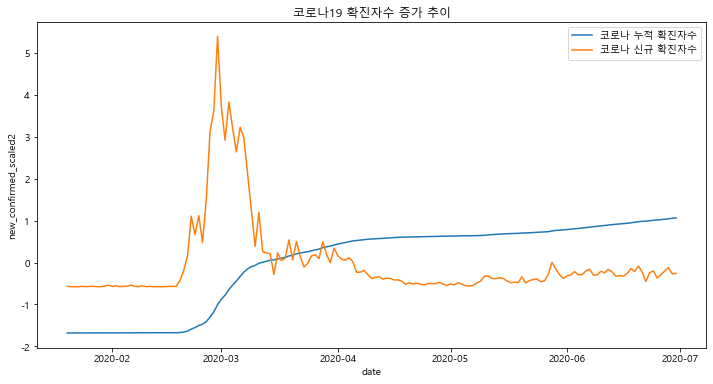

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=covid, x='date', y='confirmed_scaled2', ci=None, label='코로나 누적 확진자수')
sns.lineplot(data=covid, x='date', y='new_confirmed_scaled2', ci=None, label='코로나 신규 확진자수')
plt.legend()
plt.title("코로나19 확진자수 증가 추이")
plt.show()

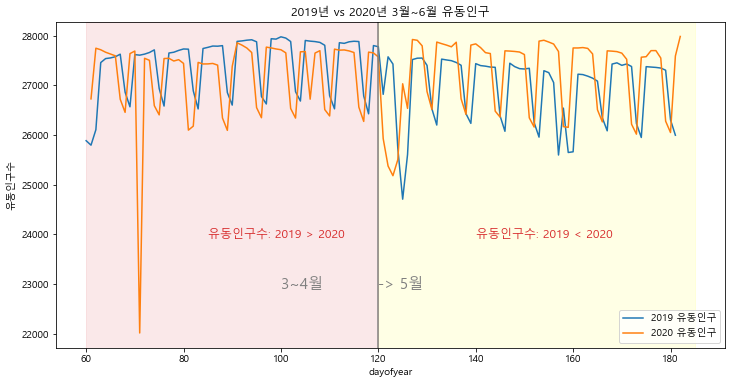

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=popul19, x='dayofyear', y='유동인구수', ci=None, label='2019 유동인구')
sns.lineplot(data=popul_covid, x='dayofyear', y='유동인구수', ci=None, label='2020 유동인구')


plt.axvspan(60, 120, alpha=0.1, color='tab:red')
plt.text(140, 24000, '유동인구수: 2019 < 2020',
             horizontalalignment='left',
             verticalalignment='center',
             color='tab:red', size=12)

plt.axvspan(120, 185, alpha=0.1, color='yellow')
plt.text(85, 24000, '유동인구수: 2019 > 2020',
             horizontalalignment='left',
             verticalalignment='center',
             color='tab:red', size=12)


plt.axvline(x=120, color='tab:gray')
plt.text(120, 23000, '-> 5월',
             horizontalalignment='left',
             verticalalignment='center',
             color='tab:gray', size=15)
plt.text(100, 23000, '3~4월',
             horizontalalignment='left',
             verticalalignment='center',
             color='tab:gray', size=15)


plt.legend()
plt.title("2019년 vs 2020년 3월~6월 유동인구")
plt.show()

In [ ]:
# 유동인구 데이터 월별 -> 하나로 합치기
months = ['03','04','05','06','07','08','09','10'] 
pieces = pd.DataFrame(columns=['일자','시간(1시간단위)','연령대(10세단위)','성별','시','군구','유동인구수']) # 데이터프레임 틀
    
for month in months:
    piece = pd.read_csv('./01_제공데이터/유동인구/FLT_SEOUL_%sMONTH.csv' %month)
    pieces = pd.concat([pieces,piece])

    
months = ['1911','1912','2001']
for month in months:
    piece = pd.read_csv('./01_제공데이터/유동인구/Floating_Population_%s.csv' %month)
    pieces = pd.concat([pieces,piece])

popul19 = pieces.copy()
popul = pieces.copy()
popul['일자'] = pd.to_datetime(popul['일자'], format='%Y%m%d')
popul = popul[popul['일자'].dt.date <= date(2020,1,1)]

# 시간, 연령대, 유동인구수 dtype 바꾸기
popul['시간(1시간단위)'] = popul['시간(1시간단위)'].astype(int)
popul['연령대(10세단위)'] = popul['연령대(10세단위)'].astype(int)
popul['유동인구수'] = popul['유동인구수'].astype(float)

In [ ]:
df['date_hour'] = pd.to_datetime(df['date'].astype(str)+" "+df['hour'].astype(str)+":00")

# 30 ~ 60대 여성(주부)의 유동인구 데이터
popul_jubu = popul[(popul['연령대(10세단위)'].isin([30,40,50,60])) & (popul['성별']=='여성')]

# 시간별 총 유동인구수 
popul_total_time = pd.DataFrame(popul.groupby(['일자','시간(1시간단위)']).sum()['유동인구수'])
popul_total_time.reset_index(inplace=True)
popul_total_time['date_hour'] = pd.to_datetime(popul_total_time['일자'].astype(str)+" "+popul_total_time['시간(1시간단위)'].astype(str)+":00")
popul_total_time.rename({'유동인구수':'총_시간별_유동인구수'}, axis=1, inplace=True)
popul_total_time = popul_total_time[['date_hour','총_시간별_유동인구수']]

# 시간별 주부 유동인구수 
popul_jubu_time = pd.DataFrame(popul_jubu.groupby(['일자','시간(1시간단위)']).sum()['유동인구수'])
popul_jubu_time.reset_index(inplace=True)
popul_jubu_time['date_hour'] = pd.to_datetime(popul_jubu_time['일자'].astype(str)+" "+popul_jubu_time['시간(1시간단위)'].astype(str)+":00")
popul_jubu_time.rename({'유동인구수':'주부_시간별_유동인구수'}, axis=1, inplace=True)
popul_jubu_time = popul_jubu_time[['date_hour','주부_시간별_유동인구수']]

popul_time = pd.merge(popul_total_time, popul_jubu_time, on='date_hour')
popul_time['date'] = pd.to_datetime(popul_time['date_hour'].dt.date)


# 일자별 총 유동인구수
popul_total_date = pd.DataFrame(popul.groupby(['일자']).sum()['유동인구수'])
popul_total_date.reset_index(inplace=True)
popul_total_date.rename({'일자':'date','유동인구수':'총_일자별_유동인구수'}, axis=1, inplace=True)

# 일자별 주부 유동인구수
popul_jubu_date = pd.DataFrame(popul_jubu.groupby('일자').sum()['유동인구수'])
popul_jubu_date.reset_index(inplace=True)
popul_jubu_date.rename({'일자':'date','유동인구수':'주부_일자별_유동인구수'}, axis=1, inplace=True)

popul_date = pd.merge(popul_total_date, popul_jubu_date, on='date')

popul = popul_time.merge(popul_date, on='date')
popul.drop(['date'], axis=1, inplace=True)

In [ ]:
# 결측치 처리를 위한 2020년 1월, 2월 유동인구 데이터
months = ['2001','2002']
pieces = pd.DataFrame(columns=['일자','시간(1시간단위)','연령대(10세단위)','성별','시','군구','유동인구수']) # 데이터프레임 틀
for month in months:
    piece = pd.read_csv('./01_제공데이터/유동인구/Floating_Population_%s.csv' %month)
    pieces = pd.concat([pieces,piece])

popul_2020 = pieces.copy()
popul_2020['일자'] = pd.to_datetime(popul_2020['일자'], format='%Y%m%d')

# 시간, 연령대, 유동인구수 dtype 바꾸기
popul_2020['시간(1시간단위)'] = popul_2020['시간(1시간단위)'].astype(int)
popul_2020['연령대(10세단위)'] = popul_2020['연령대(10세단위)'].astype(int)
popul_2020['유동인구수'] = popul_2020['유동인구수'].astype(float)

popul_2020['요일'] = popul_2020['일자'].apply(lambda x: x.strftime('%A'))
popul_2020['weekofyear'] = popul_2020['일자'].dt.weekofyear
popul_2020['week_요일'] = popul_2020['weekofyear'].astype(str)+"_"+popul_2020['요일'].astype(str)
popul_2020['week_요일_시간'] = popul_2020['weekofyear'].astype(str)+"_"+popul_2020['요일'].astype(str)+"_"+popul_2020['시간(1시간단위)'].astype(str)

In [ ]:
# 2019년 1월, 2월의 유동인구가 들어갈 틀: popul_2019_12
date_time = []
for j in range(59*24):
    date_time.append(datetime(2019,1,1,0,0) + timedelta(hours=j))

popul_2019_12 = pd.DataFrame(date_time, columns=['date_hour'])
popul_2019_12['요일'] = popul_2019_12['date_hour'].apply(lambda x: x.strftime('%A'))
popul_2019_12['weekofyear'] = popul_2019_12['date_hour'].dt.weekofyear
popul_2019_12['week_요일'] = popul_2019_12['weekofyear'].astype(str)+"_"+popul_2019_12['요일'].astype(str)
popul_2019_12['week_요일_시간'] = popul_2019_12['weekofyear'].astype(str)+"_"+popul_2019_12['요일'].astype(str)+"_"+popul_2019_12['date_hour'].dt.hour.astype(str)

In [ ]:
# 30 ~ 60대 여성(주부)의 유동인구 데이터
popul_jubu_12 = popul_2020[(popul_2020['연령대(10세단위)'].isin([30,40,50,60])) & (popul_2020['성별']=='여성')]

# 시간별 총 유동인구 채우기
popul_total_time_12 = pd.DataFrame(popul_2020.groupby(['week_요일_시간']).sum()['유동인구수'])
popul_total_time_12.reset_index(inplace=True)
popul_total_time_12.rename({'일자':'date','유동인구수':'총_시간별_유동인구수'}, axis=1, inplace=True)
popul_total_time_12 = pd.merge(popul_2019_12[['date_hour','week_요일_시간']], popul_total_time_12, on=['week_요일_시간'], how='left')
popul_total_time_12.drop(['week_요일_시간'], axis=1, inplace=True)

# 시간별 주부 유동인구수 채우기
popul_jubu_time_12 = pd.DataFrame(popul_jubu_12.groupby(['week_요일_시간']).sum()['유동인구수'])
popul_jubu_time_12.reset_index(inplace=True)
popul_jubu_time_12.rename({'유동인구수':'주부_시간별_유동인구수'}, axis=1, inplace=True)
popul_jubu_time_12 = pd.merge(popul_2019_12[['date_hour','week_요일_시간']], popul_jubu_time_12, on=['week_요일_시간'], how='left')
popul_jubu_time_12.drop(['week_요일_시간'], axis=1, inplace=True)

# 일자별 총 유동인구수 채우기
popul_total_date_12 = pd.DataFrame(popul_2020.groupby(['week_요일']).sum()['유동인구수'])
popul_total_date_12.reset_index(inplace=True)
popul_total_date_12.rename({'유동인구수':'총_일자별_유동인구수'}, axis=1, inplace=True)
popul_total_date_12 = pd.merge(popul_2019_12[['date_hour','week_요일']], popul_total_date_12, on=['week_요일'], how='left')
popul_total_date_12.drop(['week_요일'], axis=1, inplace=True)

# 일자별 주부 유동인구수 채우기
popul_jubu_date_12 = pd.DataFrame(popul_jubu_12.groupby(['week_요일']).sum()['유동인구수'])
popul_jubu_date_12.reset_index(inplace=True)
popul_jubu_date_12.rename({'유동인구수':'주부_일자별_유동인구수'}, axis=1, inplace=True)
popul_jubu_date_12 = pd.merge(popul_2019_12[['date_hour','week_요일']], popul_jubu_date_12, on=['week_요일'], how='left')
popul_jubu_date_12.drop(['week_요일'], axis=1, inplace=True)

popul_12 = pd.concat([popul_total_time_12, popul_jubu_time_12['주부_시간별_유동인구수'], popul_total_date_12['총_일자별_유동인구수'], 
           popul_jubu_date_12['주부_일자별_유동인구수']], axis=1)

# 신정
popul_12.loc[popul_12['date_hour'].dt.date.astype(str) == '2019-01-01','총_시간별_유동인구수'] = popul_2020[popul_2020['일자'] == '2020-01-01'].groupby(['시간(1시간단위)']).sum()['유동인구수']
popul_12.loc[popul_12['date_hour'].dt.date.astype(str) == '2019-01-01','주부_시간별_유동인구수'] = popul_jubu_12[popul_jubu_12['일자'] == '2020-01-01'].groupby(['시간(1시간단위)']).sum()['유동인구수']
popul_12.loc[popul_12['date_hour'].dt.date.astype(str) == '2019-01-01','총_일자별_유동인구수'] = popul_2020.loc[popul_2020['일자'] == '2020-01-01','유동인구수'].sum()
popul_12.loc[popul_12['date_hour'].dt.date.astype(str) == '2019-01-01','주부_일자별_유동인구수'] = popul_jubu_12.loc[popul_jubu_12['일자'] == '2020-01-01','유동인구수'].sum()

# 설 연휴 첫째날: 2019-02-04 <- 2020-01-24
popul_12.loc[popul_12['date_hour'].dt.date.astype(str) == '2019-02-04','총_시간별_유동인구수'] = popul_2020[popul_2020['일자'] == '2020-01-24'].groupby(['시간(1시간단위)']).sum()['유동인구수'].values
popul_12.loc[popul_12['date_hour'].dt.date.astype(str) == '2019-02-04','주부_시간별_유동인구수'] = popul_jubu_12[popul_jubu_12['일자'] == '2020-01-24'].groupby(['시간(1시간단위)']).sum()['유동인구수'].values
popul_12.loc[popul_12['date_hour'].dt.date.astype(str) == '2019-02-04','총_일자별_유동인구수'] = popul_2020.loc[popul_2020['일자'] == '2020-01-24','유동인구수'].sum()
popul_12.loc[popul_12['date_hour'].dt.date.astype(str) == '2019-02-04','주부_일자별_유동인구수'] = popul_jubu_12.loc[popul_jubu_12['일자'] == '2020-01-24','유동인구수'].sum()

# 설 연휴 둘째날 (설날 당일): 2019-02-05 <- 2020-01-25
popul_12.loc[popul_12['date_hour'].dt.date.astype(str) == '2019-02-05','총_시간별_유동인구수'] = popul_2020[popul_2020['일자'] == '2020-01-25'].groupby(['시간(1시간단위)']).sum()['유동인구수'].values
popul_12.loc[popul_12['date_hour'].dt.date.astype(str) == '2019-02-05','주부_시간별_유동인구수'] = popul_jubu_12[popul_jubu_12['일자'] == '2020-01-25'].groupby(['시간(1시간단위)']).sum()['유동인구수'].values
popul_12.loc[popul_12['date_hour'].dt.date.astype(str) == '2019-02-05','총_일자별_유동인구수'] = popul_2020.loc[popul_2020['일자'] == '2020-01-25','유동인구수'].sum()
popul_12.loc[popul_12['date_hour'].dt.date.astype(str) == '2019-02-05','주부_일자별_유동인구수'] = popul_jubu_12.loc[popul_jubu_12['일자'] == '2020-01-25','유동인구수'].sum()

# 설 연휴 셋째날: 2019-02-06 <- 2020-01-26
popul_12.loc[popul_12['date_hour'].dt.date.astype(str) == '2019-02-06','총_시간별_유동인구수'] = popul_2020[popul_2020['일자'] == '2020-01-26'].groupby(['시간(1시간단위)']).sum()['유동인구수'].values
popul_12.loc[popul_12['date_hour'].dt.date.astype(str) == '2019-02-06','주부_시간별_유동인구수'] = popul_jubu_12[popul_jubu_12['일자'] == '2020-01-26'].groupby(['시간(1시간단위)']).sum()['유동인구수'].values
popul_12.loc[popul_12['date_hour'].dt.date.astype(str) == '2019-02-06','총_일자별_유동인구수'] = popul_2020.loc[popul_2020['일자'] == '2020-01-26','유동인구수'].sum()
popul_12.loc[popul_12['date_hour'].dt.date.astype(str) == '2019-02-06','주부_일자별_유동인구수'] = popul_jubu_12.loc[popul_jubu_12['일자'] == '2020-01-26','유동인구수'].sum()

In [ ]:
popul = pd.concat([popul_12, popul], axis=0)
df = pd.merge(df, popul, on='date_hour', how='left')

In [ ]:
# 유동인구 결측치 채우기
# 2019-03-03 <- 2019-03-10
df.loc[df['date_hour'] == datetime(2019,3,3,17),['총_시간별_유동인구수','주부_시간별_유동인구수','총_일자별_유동인구수','주부_일자별_유동인구수']] = \
popul.loc[popul['date_hour'] == datetime(2019,3,10,17),['총_시간별_유동인구수','주부_시간별_유동인구수','총_일자별_유동인구수','주부_일자별_유동인구수']].values

# 2019-10-19 <- 2019-10-12
for hour in range(24):
    df.loc[df['date_hour'] == datetime(2019,10,19,hour),['총_시간별_유동인구수','주부_시간별_유동인구수','총_일자별_유동인구수','주부_일자별_유동인구수']] = \
    popul.loc[popul['date_hour'] == datetime(2019,10,12,hour),['총_시간별_유동인구수','주부_시간별_유동인구수','총_일자별_유동인구수','주부_일자별_유동인구수']].values

# 2019-10-20 <- 2019-10-13
df.loc[df['date_hour'] == datetime(2019,10,20,22),['총_시간별_유동인구수','주부_시간별_유동인구수','총_일자별_유동인구수','주부_일자별_유동인구수']] = \
popul.loc[popul['date_hour'] == datetime(2019,10,13,22),['총_시간별_유동인구수','주부_시간별_유동인구수','총_일자별_유동인구수','주부_일자별_유동인구수']].values

# 2019-11-09 <- 2019-11-16
df.loc[df['date_hour'] == datetime(2019,11,9,9),['총_시간별_유동인구수','주부_시간별_유동인구수','총_일자별_유동인구수','주부_일자별_유동인구수']] = \
popul.loc[popul['date_hour'] == datetime(2019,11,16,9),['총_시간별_유동인구수','주부_시간별_유동인구수','총_일자별_유동인구수','주부_일자별_유동인구수']].values

for hour in range(16,24):
    df.loc[df['date_hour'] == datetime(2019,11,9,hour),['총_시간별_유동인구수','주부_시간별_유동인구수','총_일자별_유동인구수','주부_일자별_유동인구수']] = \
    popul.loc[popul['date_hour'] == datetime(2019,11,16,hour),['총_시간별_유동인구수','주부_시간별_유동인구수','총_일자별_유동인구수','주부_일자별_유동인구수']].values


### 최종 분석 데이터

In [ ]:
df.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,평균시청률,연도,...,체감 물가,year_month,실업률,소비자심리지수,프로모션기간,date_hour,총_시간별_유동인구수,주부_시간별_유동인구수,총_일자별_유동인구수,주부_일자별_유동인구수
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,0.0,2019,...,384.356035,2019-1,4.5,98,0,2019-01-01 06:00:00,7913290.0,2871340.0,192406170.0,69662660.0
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,0.0,2019,...,384.356035,2019-1,4.5,98,0,2019-01-01 06:00:00,7913290.0,2871340.0,192406170.0,69662660.0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,0.0,2019,...,384.356035,2019-1,4.5,98,0,2019-01-01 06:00:00,7913290.0,2871340.0,192406170.0,69662660.0
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,0.0,2019,...,384.356035,2019-1,4.5,98,0,2019-01-01 06:00:00,7913290.0,2871340.0,192406170.0,69662660.0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,0.0,2019,...,384.356035,2019-1,4.5,98,0,2019-01-01 06:00:00,7913290.0,2871340.0,192406170.0,69662660.0


In [ ]:
# csv로 뽑아내기
df.to_csv('df_train.csv')

# 3. 모델링
- 의사결정트리
- 랜덤포레스트
- Gradient Boosting
- XGB
- LightGBM


In [ ]:
# 모델링에 필요한 라이브러리

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, precision_score, f1_score, recall_score, accuracy_score, average_precision_score # Evaluation
from sklearn.metrics import precision_score, recall_score, classification_report

# 모델 저장 라이브러리
from sklearn import datasets
import pickle
import joblib

In [ ]:
# 평가 지표
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
df_train = pd.read_csv('df_train.csv')

### 1. 의사결정트리

In [ ]:
# 사용할 입력변수
features =  ['노출(분)', '상품군', '판매단가','상품코드', '월',
       'hour', '주말여부', '분기','weekofyear',
       'dayofyear', 'endtime', '총노출', '가격대', '평균기온(°C)',
       '최고기온(°C)', '일강수량(mm)', '평균 풍속(m/s)',
       '주평균기온', '기온차', '물가지수', '체감 물가',
       '실업률','순서','주부_시간별_유동인구수']

X = df_train[features]
y = df['주문량']

# 훈련세트/테스트세트 나누기
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2020)

# 연속형 변수 처리
numeric_features = ['노출(분)','판매단가','총노출','평균기온(°C)', '최고기온(°C)','dayofyear',
                    '일강수량(mm)', '평균 풍속(m/s)','주평균기온','기온차','물가지수','체감 물가','실업률',
                    '상품코드','weekofyear','순서','주부_시간별_유동인구수']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# 범주형 변수 OneHotEncoding처리
categorical_features = ['월','hour','상품군','분기','가격대']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

## 의사결정나무
from sklearn.tree import DecisionTreeRegressor
 
# DecisionTree pipeline
pipe_dt = make_pipeline(preprocessor,DecisionTreeRegressor(max_depth=10, random_state=2020)) 
pipe_dt.fit(X_train, y_train)
y_pred = pipe_dt.predict(X_test)
print("Decision Tree MAPE: %.3f" % mean_absolute_percentage_error(y_test, y_pred))

Decision Tree MAPE: 91.403


### 2. 랜덤포레스트

In [ ]:
# 사용할 입력변수
features =  ['노출(분)', '상품군', '판매단가','상품코드','마더코드',
        'hour', '주말여부', '분기','weekofyear',
       'dayofyear', 'endtime', '총노출', '가격대', '평균기온(°C)',
       '최고기온(°C)', '일강수량(mm)', '평균 풍속(m/s)', 
       '주평균기온', '기온차', '물가지수', '체감 물가',
       '실업률','순서']

X = df_train[features]
y = df_train['주문량']

# 훈련세트/테스트세트 나누기
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2020)

# 연속형 변수 처리
numeric_features = ['노출(분)','판매단가','총노출','평균기온(°C)', '최고기온(°C)','dayofyear',
                    '일강수량(mm)', '평균 풍속(m/s)', '주평균기온','기온차','물가지수','체감 물가','실업률',
                    '상품코드','weekofyear','마더코드','순서']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# 범주형 변수 OneHotEncoding처리
categorical_features = ['hour','상품군','분기','가격대']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
 
# 랜덤포레스트 파이프라인
from sklearn.ensemble import RandomForestRegressor
pipe_rf = make_pipeline(preprocessor,RandomForestRegressor(n_estimators=1000,random_state=2020)) 
pipe_rf.fit(X_train, y_train)

y_rf_pred = pipe_rf.predict(X_test)
print("Random Forest MAPE: %.3f" % mean_absolute_percentage_error(y_test, y_rf_pred))

Random Forest MAPE: 53.874


Text(0.5, 1.0, 'Fitted vs True')

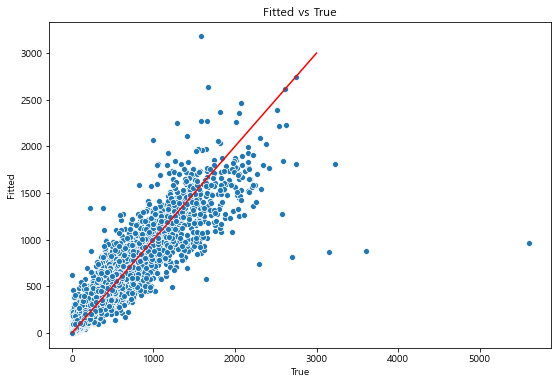

In [ ]:
plt.figure(figsize=(9,6))
sns.scatterplot(y_test,y_rf_pred)
x = np.arange(1,3000)
y=x
plt.plot(x,y,'r')
plt.xlabel("True")
plt.ylabel("Fitted")
plt.title("Fitted vs True")

### 4. Gradient Boosting

In [ ]:
# 사용할 입력변수
features =  ['노출(분)', '상품군', '판매단가','상품코드','마더코드',
       '월', 'hour', '주말여부', '분기','weekofyear',
       'dayofyear', 'endtime', '총노출', '가격대', '평균기온(°C)',
       '최고기온(°C)', '일강수량(mm)', '평균 풍속(m/s)', 
       '주평균기온', '기온차', '물가지수', '체감 물가',
       '실업률','순서','총_시간별_유동인구수']

X = df_train[features]
y = df_train['주문량']

# 훈련세트/테스트세트 나누기

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2020)

# 연속형 변수 처리
numeric_features = ['노출(분)','판매단가','총노출','평균기온(°C)', '최고기온(°C)','dayofyear',
                    '일강수량(mm)', '평균 풍속(m/s)', '주평균기온','기온차','물가지수','체감 물가','실업률',
                    '상품코드','weekofyear','마더코드','순서','총_시간별_유동인구수']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# 범주형 변수 OneHotEncoding처리
categorical_features = ['월','hour','상품군','분기','가격대']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
 
# 그래디언트 부스팅
from sklearn.ensemble import GradientBoostingRegressor

# 그래디언트부스팅 pipeline
pipe_gb = make_pipeline(preprocessor,GradientBoostingRegressor(max_depth=10, random_state=2020)) 
pipe_gb.fit(X_train, y_train)
y_pred = pipe_gb.predict(X_test)
print("Gradient Boosting MAPE: %.3f" % mean_absolute_percentage_error(y_test, y_pred))

Gradient Boosting MAPE: 55.651


### 5. XGBoost

In [ ]:
# 사용할 입력변수
features =  ['노출(분)', '상품군', '판매단가','상품코드','마더코드',
       '월', '요일', 'hour', '주말여부', '분기',
       'dayofyear', 'endtime', '총노출', '가격대', '평균기온(°C)',
       '최저기온(°C)', '최고기온(°C)', '일강수량(mm)', '평균 풍속(m/s)', '평균 상대습도(%)', '강수유무',
       '폭염', '한파', 'weekofyear', '주평균기온', '기온차', '물가지수', '체감 물가',
       '실업률', '순서']

X = df_train[features]
y = df_train['주문량']

# 훈련세트/테스트세트 나누기
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2020)

# 연속형 변수 처리
numeric_features = ['노출(분)','판매단가','총노출','평균기온(°C)', '최저기온(°C)','최고기온(°C)','dayofyear','weekofyear',
                    '일강수량(mm)', '평균 풍속(m/s)', '평균 상대습도(%)', '주평균기온','기온차','물가지수','체감 물가','실업률',
                    '상품코드','마더코드','순서']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# 범주형 변수 OneHotEncoding처리
categorical_features = ['월','요일','hour','상품군','분기','가격대']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

## XGBRegressor
from xgboost import XGBRegressor

# XGBRegressor pipeline
pipe_xgb = make_pipeline(preprocessor,XGBRegressor())

# 파라미터 목록
param_grid = {'xgbregressor__objective':['reg:squarederror'],
              'xgbregressor__learning_rate': [0.2],
              'xgbregressor__max_depth': [10],
              'xgbregressor__min_child_weight': [5]
               }

# 그리드서치
gs_xgb = GridSearchCV(estimator=pipe_xgb,
                  param_grid=param_grid,
                  cv=2,
                  scoring = 'neg_mean_absolute_error', 
                  n_jobs=-1)

gs_xgb.fit(X_train, y_train)
print("최적의 매개변수 조합: %s" %gs_xgb.best_params_)

reg_xgb = gs_xgb.best_estimator_
y_pred = reg_xgb.predict(X_test)
print("MAPE: %.3f" % mean_absolute_percentage_error(y_test, y_pred))

최적의 매개변수 조합: {'xgbregressor__learning_rate': 0.2, 'xgbregressor__max_depth': 10, 'xgbregressor__min_child_weight': 5, 'xgbregressor__objective': 'reg:squarederror'}
MAPE: 55.640


### 6. LightGBM

In [ ]:
# 사용할 입력변수
features =  ['노출(분)', '상품군', '판매단가','상품코드','마더코드',
       '월', '요일', 'hour', '주말여부', '분기',
       'dayofyear', '명절전', 'endtime', '총노출', '시청률 높은 시간대', '가격대', '평균기온(°C)',
       '최저기온(°C)', '최고기온(°C)', '일강수량(mm)', '평균 풍속(m/s)', '평균 상대습도(%)', '강수유무',
       '폭염', '한파', 'weekofyear', '주평균기온', '기온차', '물가지수', '체감 물가',
       '실업률', '순서']

X = df_train[features]
y = df_train['주문량']

# 훈련세트/테스트세트 나누기
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2020)

# 연속형 변수 처리
numeric_features = ['노출(분)','판매단가','총노출','평균기온(°C)', '최저기온(°C)','최고기온(°C)','dayofyear','weekofyear',
                    '일강수량(mm)', '평균 풍속(m/s)', '평균 상대습도(%)', '주평균기온','기온차','물가지수','체감 물가','실업률',
                    '상품코드','마더코드','순서']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# 범주형 변수 OneHotEncoding처리
categorical_features = ['월','요일','hour','상품군','분기','가격대']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

## LGBMRegressor
from lightgbm import LGBMRegressor
 
# XGBRegressor pipeline
pipe_lgbm = make_pipeline(preprocessor,LGBMRegressor())
 
# 파라미터 목록
param_grid = {'lgbmregressor__objective':['regression'],
              'lgbmregressor__learning_rate': [0.01, 0.05, 0.1, 0.2], 
              'lgbmregressor__max_depth': [1, 5, 10],
              'lgbmregressor__min_child_weight': [3, 4, 5]
               }
 
# 그리드서치
gs_lgbm = GridSearchCV(estimator=pipe_lgbm,
                  param_grid=param_grid,
                  cv=5,
                  scoring = 'neg_mean_absolute_error', 
                  n_jobs=-1)
 
gs_lgbm.fit(X_train, y_train)
 
print("최적의 매개변수 조합: %s" %gs_lgbm.best_params_)
reg_lgbm = gs_lgbm.best_estimator_
 
y_pred = reg_lgbm.predict(X_test)
print("MAPE: %.3f" % mean_absolute_percentage_error(y_test, y_pred))

최적의 매개변수 조합: {'lgbmregressor__learning_rate': 0.2, 'lgbmregressor__max_depth': 10, 'lgbmregressor__min_child_weight': 3, 'lgbmregressor__objective': 'regression'}
MAPE: 86.944


# 4. 예측

In [ ]:
# 실적 데이터 raw
raw2020 = pd.read_excel('./02_평가데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx', sheet_name='6월편성', header=1)

In [ ]:
###실적데이터에 평균 시청률 넣기(df 관련 코드 전부)
import math
df_test = raw2020
df_test['연도'] = df_test['방송일시'].dt.year
df_test['월'] = df_test['방송일시'].dt.month
df_test['요일'] = df_test['방송일시'].apply(lambda x: x.strftime('%A'))
df_test['주문량'] = df_test['취급액']/df_test['판매단가']
df_test['hour'] =  df_test['방송일시'].dt.hour
df_test['date'] = pd.to_datetime(df_test['방송일시'].dt.date)
df_test['주말여부'] = df_test['요일'].apply(lambda x: 1 if (x=='Saturday')|(x=='Sunday') else 0)
df_test['공휴일여부'] = df_test['date'].apply(lambda x: 1 if (x==pd.to_datetime('2019-06-06')) else 0)
df_test['분기'] = df_test['월'].apply(lambda x: (x-1)//3 + 1)
df_test['dayofyear'] = df_test['date'].dt.dayofyear

# 마지막시간대인지 여부 변수 생성
df_test['endtime'] = 0
df_test['총노출'] = 0
for i in range(len(df_test)):
  if i==len(df_test)-1:
    df_test.loc[i,'endtime']=1
  elif math.isnan(df_test.loc[i,'노출(분)'])==False & math.isnan(df_test.loc[i+1,'노출(분)']):
    c=0
    while(math.isnan(df_test.loc[i+c+1,'노출(분)'])):
      c += 1
    if df_test.loc[i,'상품코드'] != df_test.loc[i+c+1,'상품코드']:
      df_test.loc[i,'endtime']=1
  elif math.isnan(df_test.loc[i,'노출(분)']):
    df_test.loc[i,'endtime']=0
  elif df_test.loc[i,'상품코드'] != df_test.loc[i+1,'상품코드']:
    df_test.loc[i,'endtime']=1
 
for i in range(len(df_test)):
  if i==0: df_test.loc[i,'총노출']=0
  elif (df_test.loc[i,'endtime']==1) & (df_test.loc[i-1,'endtime']==1):
    df_test.loc[i,'총노출'] = df_test.loc[i,'노출(분)']
  elif i==2:
    df_test.loc[i,'총노출'] = 60
  elif df_test.loc[i,'endtime']==1:
    c=0
    df_test.loc[i,'총노출'] = df_test.loc[i,'노출(분)']
    while(df_test.loc[i-c-1,'endtime']!=1):
      c += 1
      if math.isnan(df_test.loc[i-c,'노출(분)'])==False:
        df_test.loc[i,'총노출'] += df_test.loc[i-c,'노출(분)']

for i in range(len(df_test)):
  if i==0: df_test.loc[i,'순서']=1
  elif i==1: df_test.loc[i,'순서']=2
  elif i==2: df_test.loc[i,'순서']=3
  elif math.isnan(df_test.loc[i,'노출(분)']): continue
  else:
    c=0
    while(math.isnan(df_test.loc[i-c-1,'노출(분)'])): c+=1
    if (df_test.loc[i-c-1,'endtime']==1): df_test.loc[i,'순서']=1
    else: df_test.loc[i,'순서']=df_test.loc[i-c-1,'순서']+1
    
df_test['순서'] = df_test['순서'].replace(0, np.NaN) 

for i in range(len(df_test)):
  if math.isnan(df_test.loc[i,'노출(분)']):
    c=0
    while(math.isnan(df_test.loc[i-c-1,'노출(분)'])):
      c+=1
    if df_test.loc[i-c-1,'endtime']==1:
      df_test.loc[i,'endtime']=1
 
for i in range(len(df_test)):
  if (df_test.loc[i,'endtime']==1) & (df_test.loc[i,'총노출']==0):
    c=0
    while(df_test.loc[i-c-1,'총노출']==0):
      c+=1
    df_test.loc[i,'총노출']=df_test.loc[i-c-1,'총노출']
  elif df_test.loc[i,'총노출']==0:
    c=0
    while(df_test.loc[i+c+1,'총노출']==0):
      c+=1
    df_test.loc[i,'총노출']=df_test.loc[i+c+1,'총노출']

# 가격대 변수 추가
df_test['가격대'] = df_test['판매단가'].apply(lambda x: 1 if (x<69000) else (2 if (x<218000) else 3)) 

## 결측치 처리
df_test = df_test[df_test['판매단가']!=0] # 판매 단가가 0인 상품 제외
df_test = df_test.fillna(method='ffill')

# 시청률 높은 시간대: 14, 17, 15, 10, 16, 11
df_test['시청률 높은 시간대'] = df_test['hour'].apply(lambda x: 1 if x in [14, 17, 15, 10, 16, 11] else 0)

In [ ]:
weather06 = pd.read_excel('./02_평가데이터/OBS_ASOS_DD_20200920125015.xlsx')
weather0701 = pd.read_excel('./02_평가데이터/OBS_ASOS_DD_20200927214035.xlsx')
weather2020 = pd.concat([weather06, weather0701], axis=0)

weather2020 = weather2020[['일시', '평균기온(°C)', '최저기온(°C)','최고기온(°C)','일강수량(mm)','평균 풍속(m/s)','평균 상대습도(%)']]
weather2020.rename({'일시':'date'}, axis=1, inplace=True)
weather2020.loc[weather2020['일강수량(mm)'].isnull(),'일강수량(mm)'] = 0 # 일강수량 결측치 0으로 채우기

# 강수유무
weather2020.loc[weather2020['일강수량(mm)']!=0, '강수유무'] = 1
weather2020.loc[weather2020['일강수량(mm)']==0, '강수유무'] = 0

# 폭염, 한파 여부
weather2020['폭염'] = weather2020['최고기온(°C)'].apply(lambda x: 1 if x>=30 else 0)
weather2020['한파'] = weather2020['최저기온(°C)'].apply(lambda x: 1 if x<0 else 0)

# week of year
weather2020['weekofyear'] = weather2020['date'].dt.weekofyear

temp_week = pd.DataFrame(weather2020.groupby('weekofyear').mean()['평균기온(°C)'])
temp_week.reset_index(inplace=True)
temp_week.rename({'평균기온(°C)':'주평균기온'}, axis=1, inplace=True)

# 기온차 변수 (저번주 평균기온 - 이번주 평균기온)
for i in range(1,len(temp_week)):
    temp_week.loc[i,'기온차'] = temp_week.loc[i-1,'주평균기온'] - temp_week.loc[i,'주평균기온']

weather2020 = weather2020.merge(temp_week, on='weekofyear')

df_test = pd.merge(df_test, weather2020, on='date', how='left')

In [ ]:
report2020 = pd.read_csv("./02_평가데이터/report2020.txt", sep="\t", header = 1)
df_test['물가지수'] = 0
for i in range(len(df_test)):
  m = 0
  if ((df_test.loc[i,'상품군'] == '의류') | (df_test.loc[i,'상품군'] == '속옷')): df_test.loc[i,'물가지수'] = report2020.loc[0,'의류']
  elif (df_test.loc[i,'상품군'] == '농수축'): df_test.loc[i,'물가지수']=report2020.loc[m,'식료품']
  elif (df_test.loc[i,'상품군'] == '주방'): df_test.loc[i,'물가지수']=report2020.loc[m,'주방용품 및 가정용품']
  elif (df_test.loc[i,'상품군'] == '이미용'): df_test.loc[i,'물가지수']=report2020.loc[m,'미용용품 및 미용서비스']
  elif (df_test.loc[i,'상품군'] == '가전'): df_test.loc[i,'물가지수']=report2020.loc[m,'가정용 기기']
  elif (df_test.loc[i,'상품군'] == '생활용품'): df_test.loc[i,'물가지수']=report2020.loc[m,'일상 생활용품 및 가사서비스']
  elif (df_test.loc[i,'상품군'] == '건강기능'): df_test.loc[i,'물가지수']=report2020.loc[m,'계']
  elif (df_test.loc[i,'상품군'] == '잡화'): df_test.loc[i,'물가지수']=report2020.loc[m,'계.2']
  else : df_test.loc[i,'물가지수']=report2020.loc[m,'가구ㆍ가사비품 및 카페트']

# 품목별 체감 물가: 소비자 물가지수 대비 판매단가
df_test['체감 물가'] = df_test['판매단가']/df_test['물가지수']

# 실업률
실업률 = pd.read_csv("./02_평가데이터/실업률.csv", encoding = 'euc-kr')

실업률 = 실업률.transpose()[2:]
실업률.columns = ['실업률']
실업률['date'] = 실업률.index 
실업률['year'] = 실업률['date'].apply(lambda x: int(x[:4]))
실업률['month'] = 실업률['date'].apply(lambda x: int(x[-2:]))
실업률['year_month'] = 실업률['year'].astype(str)+"-"+실업률['month'].astype(str)

df_test['year_month'] = df_test['date'].dt.year.astype(str)+"-"+df_test['date'].dt.month.astype(str)
df_test = df_test.merge(실업률[['year_month','실업률']], on='year_month')

# 소비자심리지수
소비자동향조사 = pd.read_csv("./02_평가데이터/소비자동향조사.csv", encoding = 'euc-kr')

소비자동향조사 = 소비자동향조사.transpose()[2:]
소비자동향조사.columns = ['소비자심리지수']
소비자동향조사['date'] = 소비자동향조사.index
소비자동향조사['year'] = 소비자동향조사['date'].apply(lambda x: int(x[:4]))
소비자동향조사['month'] = 소비자동향조사['date'].apply(lambda x: int(x[-2:]))
소비자동향조사['year_month'] = 소비자동향조사['year'].astype(str)+"-"+소비자동향조사['month'].astype(str)

df_test['year_month'] = df_test['date'].dt.year.astype(str)+"-"+df_test['date'].dt.month.astype(str)
df_test = df_test.merge(소비자동향조사[['year_month','소비자심리지수']], on='year_month')

### 최종 test 데이터

In [ ]:
df_test.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,연도,월,...,폭염,한파,weekofyear,주평균기온,기온차,물가지수,체감 물가,year_month,실업률,소비자심리지수
0,2020-06-01 06:20:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,...,0,0,23,21.685714,-0.485714,104.82,570.501813,2020-6,4.3,82
1,2020-06-01 06:40:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,...,0,0,23,21.685714,-0.485714,104.82,570.501813,2020-6,4.3,82
2,2020-06-01 07:00:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,...,0,0,23,21.685714,-0.485714,104.82,570.501813,2020-6,4.3,82
3,2020-06-01 07:20:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020,6,...,0,0,23,21.685714,-0.485714,104.82,666.857470,2020-6,4.3,82
4,2020-06-01 07:40:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020,6,...,0,0,23,21.685714,-0.485714,104.82,666.857470,2020-6,4.3,82


In [ ]:
# 사용할 입력변수
features =  ['노출(분)', '상품군', '판매단가','상품코드','마더코드',
       '월', 'hour', '주말여부', '분기','weekofyear',
       'dayofyear', 'endtime', '총노출', '가격대', '평균기온(°C)',
       '최고기온(°C)', '일강수량(mm)', '평균 풍속(m/s)', 
       '주평균기온', '기온차', '물가지수', '체감 물가',
       '실업률','순서']

X_test = df_test[features]

# 연속형 변수 처리
numeric_features = ['노출(분)','판매단가','총노출','평균기온(°C)', '최고기온(°C)','dayofyear',
                    '일강수량(mm)', '평균 풍속(m/s)', '주평균기온','기온차','물가지수','체감 물가','실업률',
                    '상품코드','weekofyear','마더코드','순서']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# 범주형 변수 OneHotEncoding처리
categorical_features = ['월','hour','상품군','분기','가격대']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [ ]:
# 랜덤 포레스트 모델로 최종 예측
y_test = pipe_rf.predict(X_test)

In [ ]:
df_test['주문량'] = y_test

In [ ]:
df_test['취급액'] = df_test['주문량'] * df_test['판매단가']

In [ ]:
# 예측 실적(취급액)이 포함된 test data
df_test.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,연도,월,...,폭염,한파,weekofyear,주평균기온,기온차,물가지수,체감 물가,year_month,실업률,소비자심리지수
0,2020-06-01 06:20:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,1.228099e+07,2020,6,...,0,0,23,21.685714,-0.485714,104.82,570.501813,2020-6,4.3,82
1,2020-06-01 06:40:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,2.032347e+07,2020,6,...,0,0,23,21.685714,-0.485714,104.82,570.501813,2020-6,4.3,82
2,2020-06-01 07:00:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,4.479765e+07,2020,6,...,0,0,23,21.685714,-0.485714,104.82,570.501813,2020-6,4.3,82
3,2020-06-01 07:20:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,1.663484e+07,2020,6,...,0,0,23,21.685714,-0.485714,104.82,666.857470,2020-6,4.3,82
4,2020-06-01 07:40:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,2.991786e+07,2020,6,...,0,0,23,21.685714,-0.485714,104.82,666.857470,2020-6,4.3,82


In [ ]:
df_test.to_csv('df_test.csv')